In [6]:
# Import necessary libraries
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

In [11]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Alzheimer's Disease Analysis") \
    .getOrCreate()

# Fetch data from API URL
url = "http://localhost:5000/data"
response = requests.get(url)
response.raise_for_status()

# Convert JSON data to a Pandas DataFrame
alzheimers_df = pd.DataFrame(response.json())

# Convert Pandas DataFrame to Spark DataFrame
alzheimers_sdf = spark.createDataFrame(alzheimers_df)

# Display information about the Pandas DataFrame
alzheimers_df.info()

# Print schema of the Spark DataFrame
alzheimers_sdf.printSchema()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ADL                        2149 non-null   float64
 1   Age                        2149 non-null   int64  
 2   AlcoholConsumption         2149 non-null   float64
 3   BMI                        2149 non-null   float64
 4   BehavioralProblems         2149 non-null   int64  
 5   CardiovascularDisease      2149 non-null   int64  
 6   CholesterolHDL             2149 non-null   float64
 7   CholesterolLDL             2149 non-null   float64
 8   CholesterolTotal           2149 non-null   float64
 9   CholesterolTriglycerides   2149 non-null   float64
 10  Confusion                  2149 non-null   int64  
 11  Depression                 2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Diagnosis                  2149 non-null   int64

In [3]:
# Create Spark session
spark = SparkSession.builder \
    .appName("Alzheimer's Disease Analysis") \
    .getOrCreate()

# Load the CSV file into a Spark DataFrame
file_path = "Resources/alzheimers_disease_data.csv"
alzheimers_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema of the DataFrame
alzheimers_df.printSchema()

# Display the first few rows of the DataFrame
alzheimers_df.show(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ADL                        2149 non-null   float64
 1   Age                        2149 non-null   int64  
 2   AlcoholConsumption         2149 non-null   float64
 3   BMI                        2149 non-null   float64
 4   BehavioralProblems         2149 non-null   int64  
 5   CardiovascularDisease      2149 non-null   int64  
 6   CholesterolHDL             2149 non-null   float64
 7   CholesterolLDL             2149 non-null   float64
 8   CholesterolTotal           2149 non-null   float64
 9   CholesterolTriglycerides   2149 non-null   float64
 10  Confusion                  2149 non-null   int64  
 11  Depression                 2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Diagnosis                  2149 non-null   int64

In [15]:
#Define features and target
features = [col for col in alzheimers_sdf.columns if col not in ['PatientID', 'Diagnosis', 'DoctorInCharge']]

# StringIndexer and VectorAssembler
indexer = StringIndexer(inputCol="Diagnosis", outputCol="label")
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Create and fit the pipeline
pipeline = Pipeline(stages=[indexer, assembler])
transformed_data = pipeline.fit(alzheimers_sdf).transform(alzheimers_sdf)

# Split data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=5)

# Convert Spark DataFrame to Pandas DataFrame for sklearn
train_data_pd, test_data_pd = train_data.toPandas(), test_data.toPandas()

# Separate features and labels
X_train, y_train = train_data_pd[features], train_data_pd['label']
X_test, y_test = test_data_pd[features], test_data_pd['label']

# Standardize features
scaler = StandardScaler().fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

Py4JJavaError: An error occurred while calling o562.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 3.0 failed 1 times, most recent failure: Lost task 3.0 in stage 3.0 (TID 39) (localhost executor driver): java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:328)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:355)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:808)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:328)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:355)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:808)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)


In [47]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print(f"{model_name} Accuracy:", accuracy)
    print(f"{model_name} AUC:", auc)
    print(f"{model_name} Confusion Matrix:\n", conf_matrix)
    print(f"{model_name} Classification Report:\n", class_report)
    
    return model, y_pred, y_prob


In [48]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=500, random_state=5)

# Train and evaluate the Random Forest model
rf_model, y_pred_rf, y_prob_rf = train_and_evaluate(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")


Random Forest Accuracy: 0.9543269230769231
Random Forest AUC: 0.9639892578125
Random Forest Confusion Matrix:
 [[283   5]
 [ 14 114]]
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       288
         1.0       0.96      0.89      0.92       128

    accuracy                           0.95       416
   macro avg       0.96      0.94      0.95       416
weighted avg       0.95      0.95      0.95       416



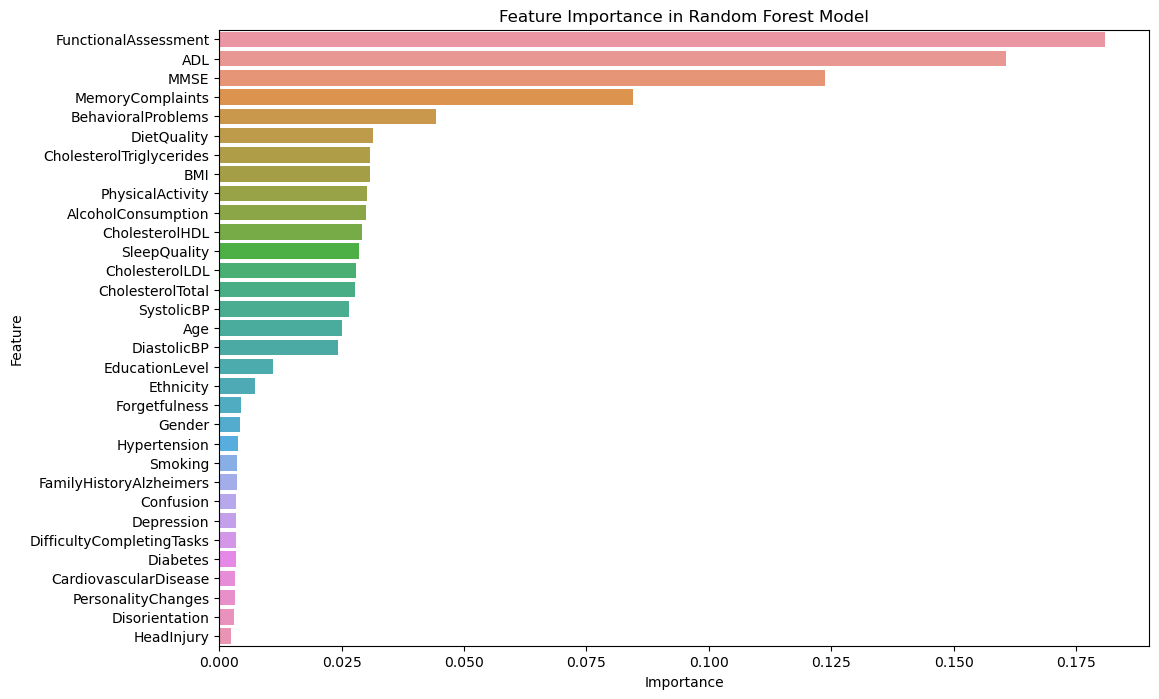

In [49]:
# Feature importance for Random Forest
rf_feature_importance = rf_model.feature_importances_
rf_importance_df = pd.DataFrame(list(zip(features, rf_feature_importance)), columns=["Feature", "Importance"])
rf_importance_df = rf_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance for Random Forest using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df)
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [50]:
# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=5)

# Train and evaluate the Decision Tree model
dt_model, y_pred_dt, y_prob_dt = train_and_evaluate(dt_model, X_train_scaled, y_train, X_test_scaled, y_test, "Decision Tree")


Decision Tree Accuracy: 0.9086538461538461
Decision Tree AUC: 0.892795138888889
Decision Tree Confusion Matrix:
 [[269  19]
 [ 19 109]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       288
         1.0       0.85      0.85      0.85       128

    accuracy                           0.91       416
   macro avg       0.89      0.89      0.89       416
weighted avg       0.91      0.91      0.91       416



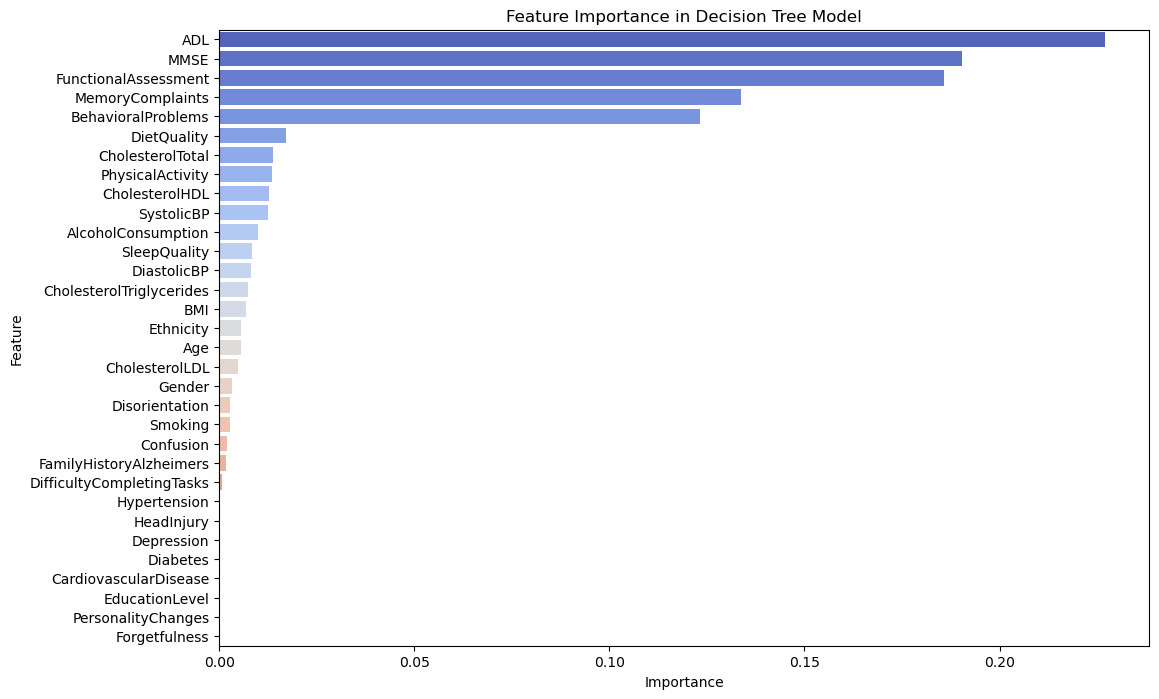

In [51]:
# Feature importance for Decision Tree
dt_feature_importance = dt_model.feature_importances_
dt_importance_df = pd.DataFrame(list(zip(features, dt_feature_importance)), columns=["Feature", "Importance"])
dt_importance_df = dt_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance for Decision Tree using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=dt_importance_df, palette='coolwarm')
plt.title('Feature Importance in Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [52]:
# Initialize Logistic Regression model
lr_model = LogisticRegression(random_state=5)

# Train and evaluate the Logistic Regression model
lr_model, y_pred_lr, y_prob_lr = train_and_evaluate(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")


Logistic Regression Accuracy: 0.84375
Logistic Regression AUC: 0.8974609375
Logistic Regression Confusion Matrix:
 [[260  28]
 [ 37  91]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       288
         1.0       0.76      0.71      0.74       128

    accuracy                           0.84       416
   macro avg       0.82      0.81      0.81       416
weighted avg       0.84      0.84      0.84       416



In [53]:
# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=5)

# Train and evaluate the Gradient Boosting model
gb_model, y_pred_gb, y_prob_gb = train_and_evaluate(gb_model, X_train_scaled, y_train, X_test_scaled, y_test, "Gradient Boosting")


Gradient Boosting Accuracy: 0.9471153846153846
Gradient Boosting AUC: 0.9620225694444444
Gradient Boosting Confusion Matrix:
 [[280   8]
 [ 14 114]]
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       288
         1.0       0.93      0.89      0.91       128

    accuracy                           0.95       416
   macro avg       0.94      0.93      0.94       416
weighted avg       0.95      0.95      0.95       416



In [54]:
# Initialize CatBoost model
cb_model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_state=5)

# Train and evaluate the CatBoost model
cb_model, y_pred_cb, y_prob_cb = train_and_evaluate(cb_model, X_train_scaled, y_train, X_test_scaled, y_test, "CatBoost")


CatBoost Accuracy: 0.9639423076923077
CatBoost AUC: 0.9640299479166666
CatBoost Confusion Matrix:
 [[283   5]
 [ 10 118]]
CatBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       288
         1.0       0.96      0.92      0.94       128

    accuracy                           0.96       416
   macro avg       0.96      0.95      0.96       416
weighted avg       0.96      0.96      0.96       416



In [55]:
# Initialize XGBoost model
xb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, verbosity=0, random_state=5, use_label_encoder=False, eval_metric='logloss')

# Train and evaluate the XGBoost model
xb_model, y_pred_xb, y_prob_xb = train_and_evaluate(xb_model, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost")


XGBoost Accuracy: 0.9543269230769231
XGBoost AUC: 0.9728732638888891
XGBoost Confusion Matrix:
 [[282   6]
 [ 13 115]]
XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       288
         1.0       0.95      0.90      0.92       128

    accuracy                           0.95       416
   macro avg       0.95      0.94      0.95       416
weighted avg       0.95      0.95      0.95       416



### ROC (Receiver Operating Characteristic) Curve and AUC (Area Under the Curve)
The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier as its discrimination threshold is varied. The Area Under the Curve (AUC) measures the entire two-dimensional area underneath the entire ROC curve.

c:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jacob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

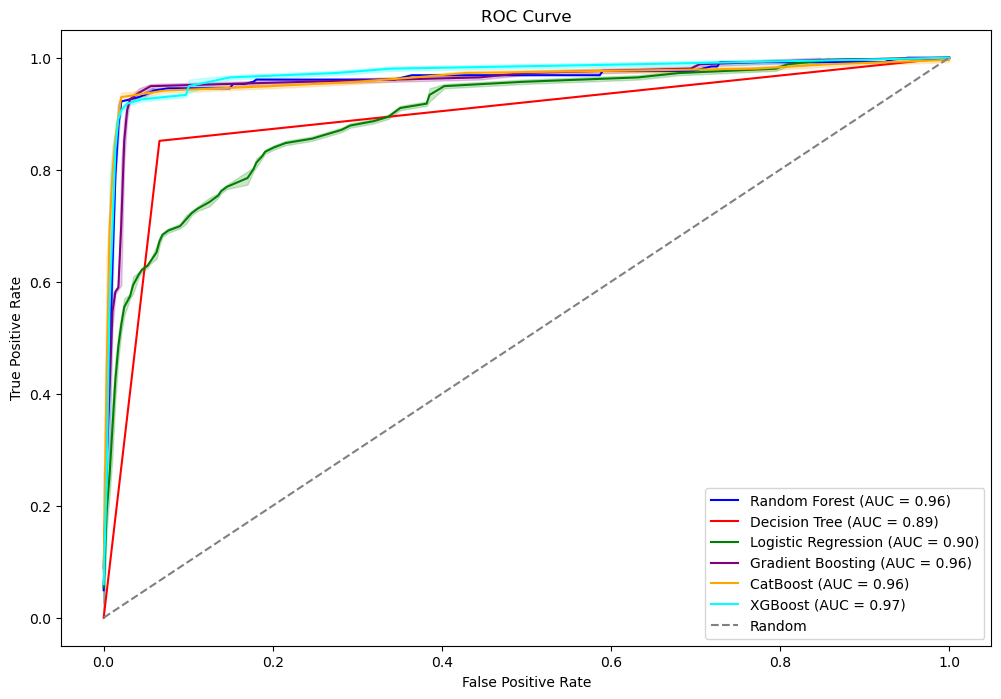

In [56]:
# Compute ROC curve for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_prob_cb)
fpr_xb, tpr_xb, _ = roc_curve(y_test, y_prob_xb)

# Plot ROC curves for all models
plt.figure(figsize=(12, 8))
sns.lineplot(x=fpr_rf, y=tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})', color='blue')
sns.lineplot(x=fpr_dt, y=tpr_dt, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_prob_dt):.2f})', color='red')
sns.lineplot(x=fpr_lr, y=tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})', color='green')
sns.lineplot(x=fpr_gb, y=tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_score(y_test, y_prob_gb):.2f})', color='purple')
sns.lineplot(x=fpr_cb, y=tpr_cb, label=f'CatBoost (AUC = {roc_auc_score(y_test, y_prob_cb):.2f})', color='orange')
sns.lineplot(x=fpr_xb, y=tpr_xb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob_xb):.2f})', color='cyan')
sns.lineplot(x=[0, 1], y=[0, 1], label='Random', color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize a dictionary to store the metrics for each model
result_list = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Combine predictions into a single DataFrame
results_df = pd.DataFrame({
    'Actual': y_test,
    'Random_Forest_Pred': y_pred_rf,
    'Decision_Tree_Pred': y_pred_dt,
    'Logistic_Regression_Pred': y_pred_lr,
    'Gradient_Boosting_Pred': y_pred_gb,
    'CatBoost_Pred': y_pred_cb,
    'XGBoost_Pred': y_pred_xb
})

# Define model names and their corresponding prediction columns
model_names = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'Gradient Boosting','CatBoost','XGBoost']
prediction_columns = ['Random_Forest_Pred', 'Decision_Tree_Pred', 'Logistic_Regression_Pred', 'Gradient_Boosting_Pred','CatBoost_Pred','XGBoost_Pred']

# Calculate metrics for each model
for model_name, pred_col in zip(model_names, prediction_columns):
    accuracy = accuracy_score(results_df['Actual'], results_df[pred_col])
    precision = precision_score(results_df['Actual'], results_df[pred_col])
    recall = recall_score(results_df['Actual'], results_df[pred_col])
    f1 = f1_score(results_df['Actual'], results_df[pred_col])
    
    result_list['Model'].append(model_name)
    result_list['Accuracy'].append(accuracy)
    result_list['Precision'].append(precision)
    result_list['Recall'].append(recall)
    result_list['F1 Score'].append(f1)
    
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Random Forest - Accuracy: 0.95, Precision: 0.96, Recall: 0.89, F1 Score: 0.92
Decision Tree - Accuracy: 0.91, Precision: 0.85, Recall: 0.85, F1 Score: 0.85
Logistic Regression - Accuracy: 0.84, Precision: 0.76, Recall: 0.71, F1 Score: 0.74
Gradient Boosting - Accuracy: 0.95, Precision: 0.93, Recall: 0.89, F1 Score: 0.91
CatBoost - Accuracy: 0.96, Precision: 0.96, Recall: 0.92, F1 Score: 0.94
XGBoost - Accuracy: 0.95, Precision: 0.95, Recall: 0.90, F1 Score: 0.92
